In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import awkward._v2 as ak

In [5]:
taxi = ak.from_parquet("https://pivarski-princeton.s3.amazonaws.com/chicago-taxi.parquet", row_groups=[0])
taxi

<Array [[{trip: {...}, ...}, ..., {...}], ...] type='353 * var * {trip: {se...'>

In [6]:
taxi.type.show()

353 * var * {
    trip: {
        sec: ?float32,
        km: ?float32,
        begin: {
            lon: ?float64,
            lat: ?float64,
            time: ?datetime64[ms]
        },
        end: {
            lon: ?float64,
            lat: ?float64,
            time: ?datetime64[ms]
        },
        path: var * {
            londiff: float32,
            latdiff: float32
        }
    },
    payment: {
        fare: ?float32,
        tips: ?float32,
        total: ?float32,
        type: string
    },
    company: string
}


In [7]:
ak.ravel(taxi.trip.begin.time)

<Array [2019-01-02T13:00:00.000, ...] type='1005530 * datetime64[ms]'>

In [8]:
trips = ak.flatten(taxi.trip)
trips

<Array [{sec: 60, km: 0, begin: ..., ...}, ...] type='1005530 * {sec: ?floa...'>

In [9]:
selected_trips = trips[~ak.is_none(trips.begin.time) & ~ak.is_none(trips.sec)]
selected_trips

<Array [{sec: 60, km: 0, begin: ..., ...}, ...] type='1005363 * {sec: ?floa...'>

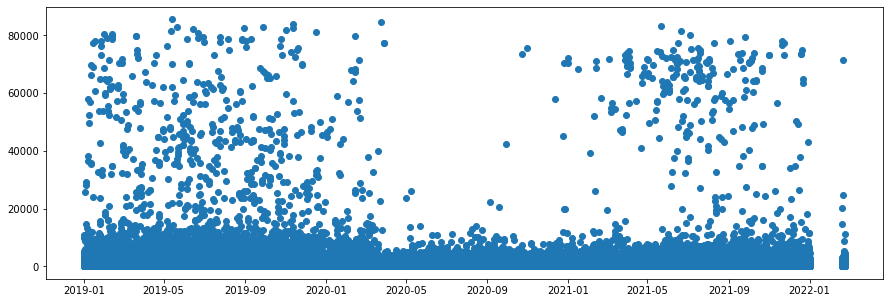

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.scatter(selected_trips.begin.time, selected_trips.sec)

In [11]:
begin_time = ak.from_parquet("https://pivarski-princeton.s3.amazonaws.com/chicago-taxi.parquet", columns="trip.begin.time")
begin_time

<Array [[{trip: {...}}, ..., {...}], ...] type='7728 * var * ?{trip: {begin...'>

<AxesSubplot:>

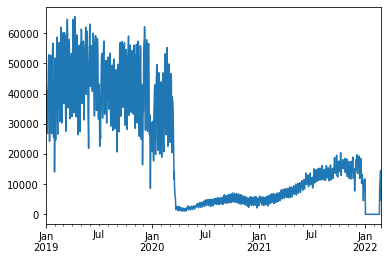

In [12]:
pd.Series(1, index=pd.Index(np.asarray(ak.ravel(begin_time.trip.begin.time)))).resample("D").sum().plot()

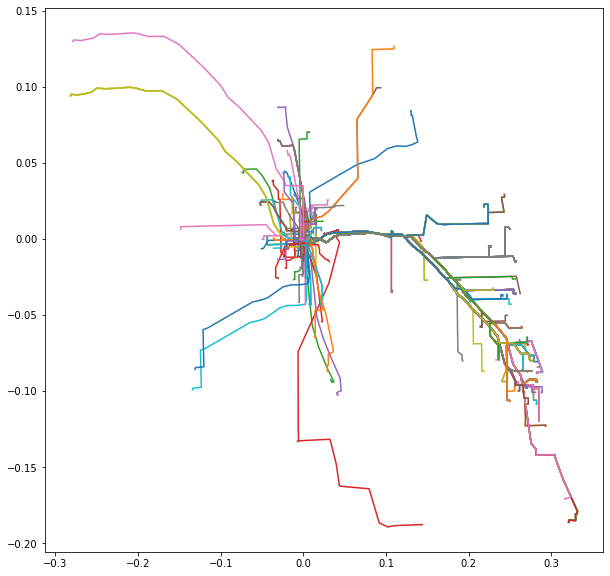

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for trip in taxi[1].trip:
    ax.plot(trip.path.londiff, trip.path.latdiff)

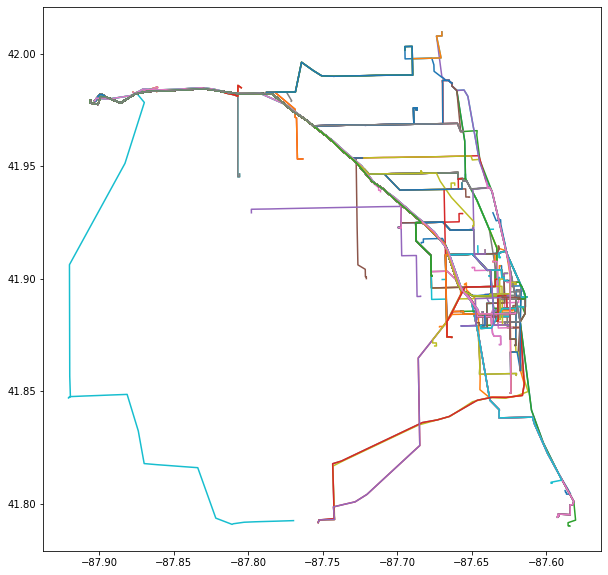

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for trip in taxi[1].trip:
    if trip.begin.lon is not None and trip.begin.lat is not None:
        longitude = trip.begin.lon + trip.path.londiff
        latitude = trip.begin.lat + trip.path.latdiff
        ax.plot(longitude, latitude)

In [15]:
good_trips = taxi.trip[
    ~ak.is_none(taxi.trip.begin.lon)
    & ~ak.is_none(taxi.trip.begin.lat)
    & ~ak.is_none(taxi.trip.end.lon)
    & ~ak.is_none(taxi.trip.end.lat)
    & (ak.num(taxi.trip.path.londiff, axis=-1) > 0)
]

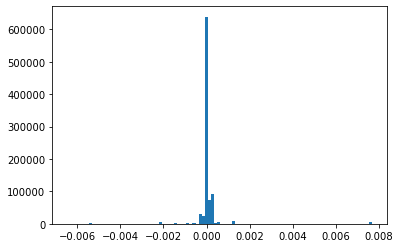

In [16]:
plt.hist(ak.ravel(good_trips.path.londiff[:, :, -1] - (good_trips.end.lon - good_trips.begin.lon)), bins=100);

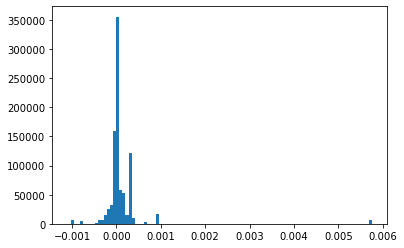

In [17]:
plt.hist(ak.ravel(good_trips.path.latdiff[:, :, -1] - (good_trips.end.lat - good_trips.begin.lat)), bins=100);

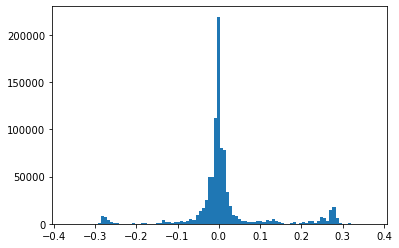

In [18]:
plt.hist(ak.ravel(good_trips.path.londiff[:, :, -1] - good_trips.path.londiff[:, :, 0]), bins=100);

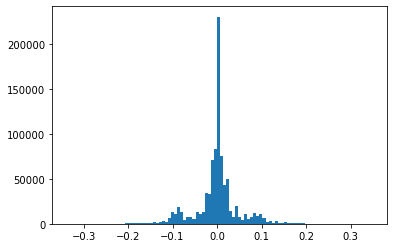

In [19]:
plt.hist(ak.ravel(good_trips.path.latdiff[:, :, -1] - good_trips.path.latdiff[:, :, 0]), bins=100);

In [20]:
km_east = (good_trips.path.londiff) * 82.98452409203695
km_north = (good_trips.path.latdiff) * 111.07127961503745

In [21]:
distances = ak.sum(np.sqrt((km_east[:, :, 1:] - km_east[:, :, :-1])**2 + (km_north[:, :, 1:] - km_north[:, :, :-1])**2), axis=-1)
distances

<Array [[0, 9.63, 6.2, 2.07, ..., 7.27, 0, 0], ...] type='353 * var * float32'>

In [22]:
crow_flies = np.sqrt((km_east[:, :, -1] - km_east[:, :, 0])**2 + (km_north[:, :, -1] - km_north[:, :, 0])**2)
crow_flies

<Array [[0, 7.82, 4.91, 1.64, ..., 5.53, 0, 0], ...] type='353 * var * float32'>

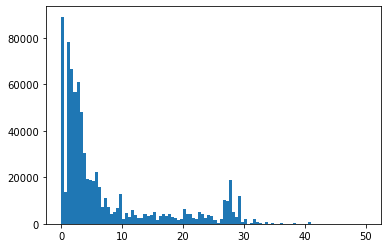

In [23]:
plt.hist(ak.ravel((distances)[good_trips.km != 0]), bins=100, range=(0, 50));

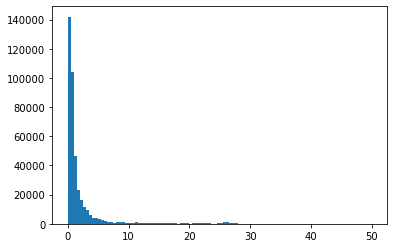

In [24]:
plt.hist(ak.ravel((distances - good_trips.km)[good_trips.km != 0]), bins=100, range=(0, 50));

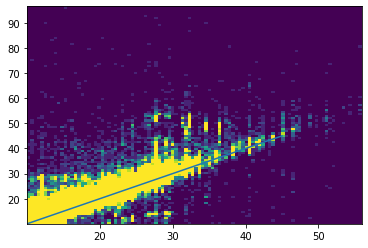

In [25]:
cut = ~ak.is_none(good_trips.km, axis=-1) & (10 < distances) & (distances < 100) & (10 < good_trips.km) & (good_trips.km < 100)
plt.hist2d(ak.ravel(distances[cut]), ak.ravel(good_trips.km[cut]), bins=(100, 100), vmax=10);
plt.plot([10, 45], [10, 45])

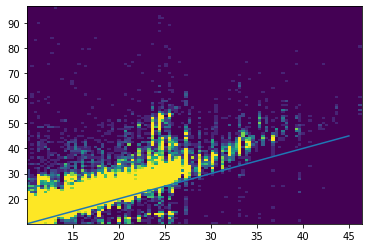

In [26]:
cut = ~ak.is_none(good_trips.km, axis=-1) & (10 < crow_flies) & (crow_flies < 100) & (10 < good_trips.km) & (good_trips.km < 100)
plt.hist2d(ak.ravel(crow_flies[cut]), ak.ravel(good_trips.km[cut]), bins=(100, 100), vmax=10);
plt.plot([10, 45], [10, 45])

/home/jpivarski/mambaforge/lib/python3.9/site-packages/awkward/_v2/_connect/numpy.py:200: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(*args, **kwargs)


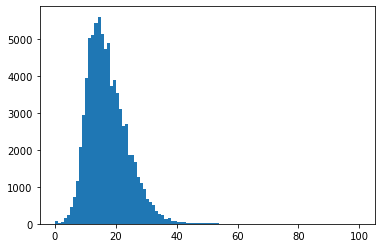

In [27]:
cut = (5 < good_trips.km) & (good_trips.km < 10)
plt.hist(ak.ravel((0.621371 * good_trips.km[cut]) / (good_trips.sec[cut] / 60 / 60)), bins=100, range=(0, 100));

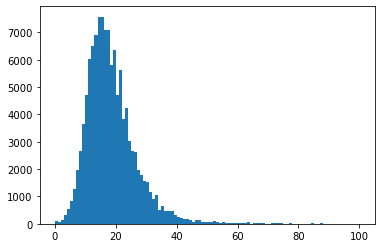

In [28]:
cut = (5 < distances) & (distances < 10)
plt.hist(ak.ravel((0.621371 * distances[cut]) / (good_trips.sec[cut] / 60 / 60)), bins=100, range=(0, 100));

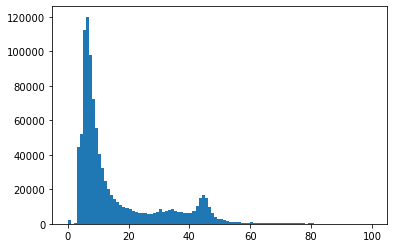

In [29]:
plt.hist(ak.ravel(taxi.payment.fare), bins=100, range=(0, 100));

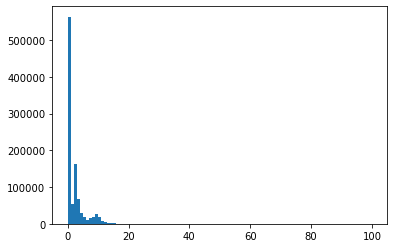

In [30]:
plt.hist(ak.ravel(taxi.payment.tips), bins=100, range=(0, 100));

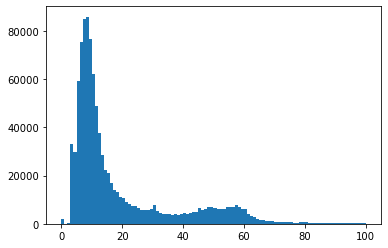

In [31]:
plt.hist(ak.ravel(taxi.payment.total), bins=100, range=(0, 100));

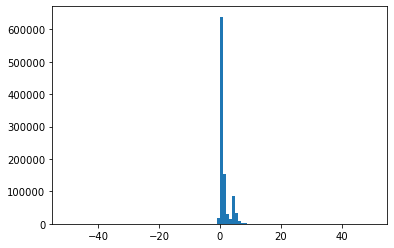

In [32]:
plt.hist(ak.ravel(taxi.payment.total - taxi.payment.fare - taxi.payment.tips), bins=100, range=(-50, 50));

In [33]:
np.unique(ak.flatten(taxi.payment["type"]).tolist(), return_counts=True)

(array(['Cash', 'Credit Card', 'Dispute', 'Mobile', 'No Charge', 'Pcard',
        'Prcard', 'Prepaid', 'Unknown'], dtype='<U11'),
 array([479027, 446665,    489,  23504,    588,     23,  32811,     32,
         22391]))

In [34]:
taxi.payment["type"] == "Cash"

<Array [[False, True, True, ..., True, True], ...] type='353 * var * bool'>